## Analyzing Iowa Housing Data: Kaggle competition
#### Matthew Johnson, August 5, 2018

### Goal <br> 
- To predict the sale price for each house.<br>

### Metric <br>
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)<br>

#### Steps taken to clean data
- Remove outliers
- Change some numeric data to categorical
- Fill in missing data
- Recode ordinal variables
- Add additional features
- Scale/transform features
- One hot encoding



In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

fileTrain = '/Users/mattjohnson/Desktop/Python2018/kaggleHousing/train.csv'
fileTest = '/Users/mattjohnson/Desktop/Python2018/kaggleHousing/test.csv'

training = pd.read_csv(fileTrain)
testing = pd.read_csv(fileTest)

print('Shape of the training data: {} '.format(training.shape))
print('Shape of the testing data: {} '.format(testing.shape))

shape of training data:  (1460, 81)
shape of testing data:  (1459, 80)


In [2]:
train = training.copy()
test = testing.copy()

# removing outliers
train = train.drop([691, 1182, 457, 769, 178, 803, 898, 1046])

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

sale_price = train['SalePrice']

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 


In [3]:
ntrain = train.shape[0]
ntest = test.shape[0]
print('ntrain =', ntrain,'\tntest =', ntest)

y_train = train.SalePrice.values
all_data = pd.concat((train, test)) #.reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

ntrain: 1452
ntest: 1459
all_data size is : (2911, 80)


### SalePrice

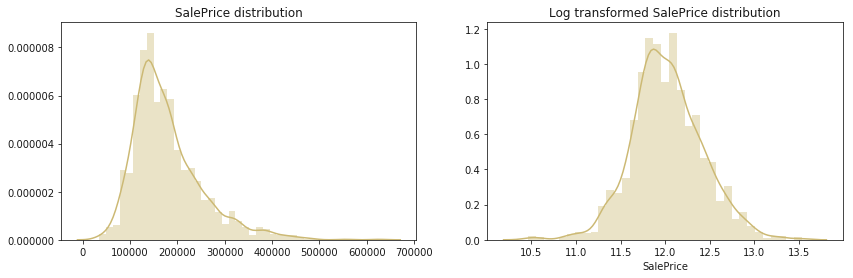

In [4]:
plt.subplots(figsize=(14,4))

sns.set_color_codes()
plt.subplot(1, 2, 1)
ax = sns.distplot(y_train, color="y").set_title('SalePrice distribution');

#log transform
plt.subplot(1, 2, 2)
df_train = training.copy()
df_train['SalePrice'] = np.log(df_train['SalePrice'])
sns.set_color_codes()
ax = sns.distplot(df_train['SalePrice'], color="y", ).set_title('Log transformed SalePrice distribution');

#### Analyzing and inputting missing data

In [5]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data = missing_data[ missing_data['Total']>0]
missing_data.head()

,Total,Percent
PoolQC,2902,0.996908
MiscFeature,2806,0.963930
Alley,2713,0.931982
Fence,2341,0.804191
FireplaceQu,1420,0.487805


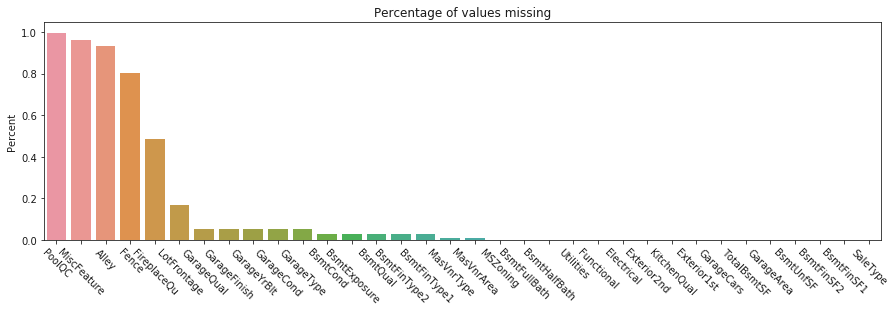

In [6]:
plt.subplots(figsize=(15,4))
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xticks(rotation=-45)
plt.title('Percentage of values missing');

### Ordinal categorical variables: Condition/Quality

Some of the categorical variables had an ordering to them, we will call them qualitative variables. To preserve that I wrote a method that takes each of those qualitative variables and orders them by the 'SalePrice' mean of that subcategory and maps the column to numerical with a dictionary. Higher number implies better. <br>
For example, *'BsmtQual' : {'Ex': 4, 'Fa': 1, 'Gd': 3, 'TA': 2, 'missing': 0}*.

In [7]:
# method for changing obj. columns of ordinal variables

def encode_ordinal_cats(dataframe):
    
    dict_list = list() # instantiate a list for dictionaries to be applied to categorical cols
    dict_key_list = list() # same for a list of keys

    df = dataframe.copy() # make copy of dataframe passed through 
        
    cat_df = df.select_dtypes(include=['object']) # for .columns loop below 
    
    for c in cat_df.columns: # loop through categorical columns
        
        df[c] = df[c].fillna('missing') # to show that data is missing

        abbrev_list = training[c].value_counts().index # list of abbreviations in category
        
        sorted_abbrevs = abbrev_list.copy()
        sorted_abbrevs = sorted_abbrevs.sort_values()
                
        # make a list of dictionaries, if all abbrevs ( 'Fa', 'Ex', etc.) are contained in a dictionaries keys and the
        # length is the same, don't bother doing calculations, skip

        if  list(sorted_abbrevs) in dict_key_list:
            
            dic_loc = dict_key_list.index(list(sorted_abbrevs))
            
            df[c].replace(dict_list[dic_loc], inplace=True) # replace old column with new ordinally labelled col

        else:

            mean_list = list() # list for each values mean saleprice
        
            for _ in abbrev_list: # loop through the abbreviations 
            
                train_df = pd.concat([df[:ntrain], training['SalePrice']], axis=1)
                mean_list.append(train_df[train_df[c]==_ ]['SalePrice'].mean()) # add to our list of means
            
            sorted_means = sorted( mean_list ) # sort our list for ordinal labeling
        
            i=0 
            dic = {} # dictionary for this category
        
            for _ in abbrev_list: # loop through abbrevs again to fill dict
            
                w = sorted_means.index(mean_list[i]) # the 'ranking' (starts at 0)

                dic.update({_:w+1}) # update our dictionary with latest entry
            
                i+=1
            
            dic.update({'missing': 0}) # update dictionary for missing data: 0 val
                     
            df[c].replace(dic, inplace=True) # replace old column with new ordinally labelled col
            
            dict_list.append(dic)
            
            l = list(dic.keys())
            l.remove('missing')
            l.sort()
            dict_key_list.append(l)

    print( '# categories:', cat_df.shape[1])
    print( '# dictionaries used:', len(dict_list))
    
    return df, dict_list, dict_key_list # return the df in use

### Filling missing data

In [8]:
def yes_to_int(k):
        
        if k=='Y':
            return 1
        else:
            return 0
        
def fill_missing_data(dataframe): 
    
    df = dataframe.copy()
    
    # Garage Year Built - setting to year house was built
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])

    # Setting Indicator variable of whether house has garage
    df['HasGarage']  = np.where(df['GarageType'] != 0, 1, 0)

    # Misc Features
    df['MiscFeature'] = df['MiscFeature'].fillna('None')
    
    # Alley
    df['Alley'] = df['Alley'].fillna('None')

    # Fence
    df['Fence'] = df['Fence'].fillna('None')

    ### Lot Frontage - come back, see what kind of housing?
    ## median / mean of neighbourhoods
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median()))

    # Setting Indicator variable of whether house has garage
    df['HasBsmt']  = np.where(df['BsmtQual'] != 0, 1, 0)

    # Masonry Veneer Type
    df['MasVnrType'] = df['MasVnrType'].fillna('None')

    # Masonry Veneer Area - fill to 0 since we assume there is none
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0.0)

    # Electrical - Sbrkr is an overwhemling majority (mode), we will fill na's with this
    df['Electrical'] = df['Electrical'].fillna('Sbrkr')

    #turn MSSubClass and MoSold into categorical types
    df['MSSubClass'] = df['MSSubClass'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)
    df['YrSold'] = df['YrSold'].astype(str)

    # add column for total SF
    df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF'] 

    # Zoning: most common is RL - residential
    df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])

    # Utilities: most common is All pub?
    df['Utilities'] = df['Utilities'].fillna(df['Utilities'].mode()[0])
    
    # paved driveway turn numeric
    df['PavedDrive'] = df['PavedDrive'].apply(yes_to_int)
    
    # central air turn numeric
    df['CentralAir'] = df['CentralAir'].apply(yes_to_int)
    
    # Determine remaining columns with null values
    null_sum = df.isnull().sum()
    null_cols = null_sum[ null_sum!=0]

    # Remainders and ones we may have missed due to future missing data
    for col in null_cols.index:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        elif df[col].dtype == 'int64':
            df[col] = df[col].fillna(df[col].median()[0])
        elif df[col].dtype == 'float64':
            df[col] = df[col].fillna(df[col].mean())
            
    # Determine remaining columns with null values
    null_sum = df.isnull().sum()
    null_cols = null_sum[ null_sum!=0]
    
    return df

### Start cleaning the data

In [9]:
# Qualitative variables that are categorical which we want to transform to ordinal numeric.
qual_vars = ['ExterQual', 'ExterCond', 'KitchenQual', 'HeatingQC', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
             'FireplaceQu', 'GarageQual', 'PoolQC', 'GarageType', 'GarageCond','GarageFinish', 'BsmtFinType1', 'BsmtFinType2']

# split qualitative predictor variables and not quals
qual_df = all_data [ qual_vars ]
nonqual_df = all_data.drop(qual_vars, axis=1)

# call method to encode data numerically in ordinal fashion
# all dicts is where we will store our dictionaries for use on testing data
qual_df, all_dicts, key_list = encode_ordinal_cats(qual_df)

# categories: 15
# dictionaries used: 8


In [10]:
# filling non qualitative predictor variables
filled_df = fill_missing_data( pd.concat([nonqual_df, qual_df[['BsmtQual', 'GarageType']]], axis=1))

all_data = pd.concat([filled_df, qual_df.drop(['BsmtQual','GarageType'], axis=1)], axis=1)
print (qual_df.shape)
print (nonqual_df.shape)
print ( all_data.shape )

(2911, 15)
(2911, 65)
(2911, 83)


## Transforming / scaling features

#### Skew

In [11]:
from scipy.stats import norm, skew

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(20)


Skew in numerical features: 



,Skew
PoolQC,22.308122
MiscVal,21.917089
PoolArea,17.763660
LotArea,13.138889
LowQualFinSF,12.071863
3SsnPorch,11.360117
KitchenAbvGr,4.295433
BsmtFinSF2,4.139470
EnclosedPorch,3.997699
ScreenPorch,3.966938


#### Box Cox Transformation

In [12]:
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
skewed_features = skewed_features.drop(['Id', 'HasGarage', 'HasBsmt'])

print("There are {} skewed numerical features to Box Cox transform".format(len(skewed_features)))

lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    

There are 51 skewed numerical features to Box Cox transform


In [13]:
print(all_data.shape)
all_data.dtypes.value_counts()

(2911, 83)


float64    51
object     29
int64       3
dtype: int64

### One hot encoding

In [14]:
print("There are {} features before one hot encoding".format(all_data.shape[1]))
all_data = pd.get_dummies(all_data)
print("There are {} features after one hot encoding".format(all_data.shape[1]))

(2911, 83)
(2911, 269)


### Correlation with the target variable

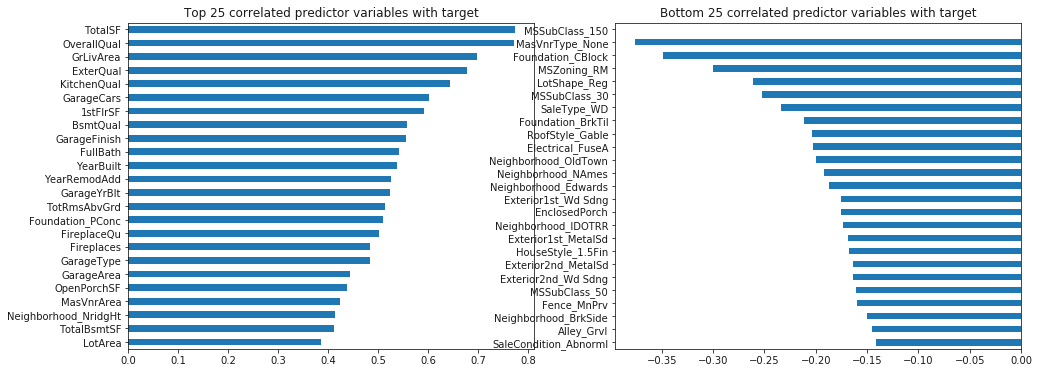

In [47]:
corr_df2 = pd.concat([all_data[:ntrain],sale_price], axis=1)

corr = corr_df2.corr()['SalePrice']

corr_rank = corr.sort_values(ascending=False)

corr_rank_high = corr_rank[1:25]
corr_rank_low = corr_rank[-25:]

plt.subplots(figsize=(16,6))

plt.subplot(1, 2, 1)
highCorrs = corr_rank_high.sort_values(ascending=True)
highCorrs.plot(kind='barh')
plt.title('Top 25 correlated predictor variables with target')

plt.subplot(1, 2, 2)
inverseCorrs = corr_rank_low.sort_values(ascending=False)
inverseCorrs.plot(kind='barh')
plt.title('Bottom 25 correlated predictor variables with target');

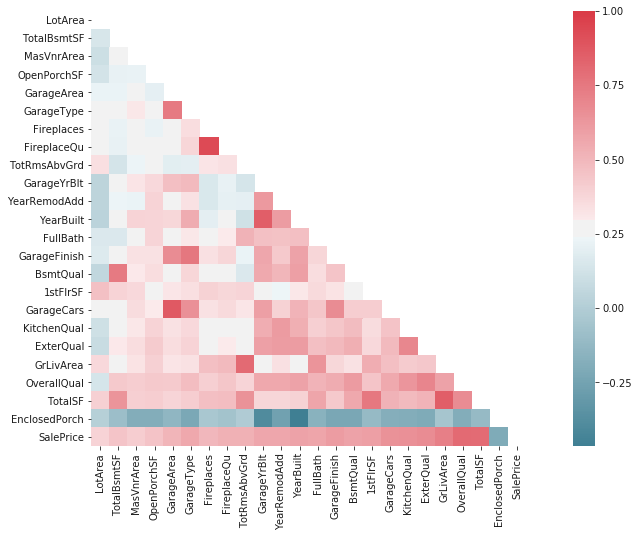

In [67]:
combined_list = list(highCorrs.index) + list(inverseCorrs.index)y_df = all_data[combined_list]
numeric_data = y_df.select_dtypes(include=['float64']) # num_df (1460, 38)
#numeric_data = numeric_data.drop(['Id'], axis=1)
numeric_data = pd.concat([numeric_data.reset_index(drop=True), pd.DataFrame({'SalePrice':y_train})], axis=1)
numeric_data_corr = numeric_data.corr()
mask = np.zeros_like(numeric_data_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(17, 8))

#  Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(numeric_data_corr, mask=mask, cmap=cmap, square=True, ax=ax);

#### Setting up training and testing data

In [15]:
ntrain = train.shape[0]

train_ID = train['Id']

train = all_data[:ntrain]
test = all_data[ntrain:]

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

y_train = np.log(1+np.array(sale_price))

print('Size of training data: {}'.format(train.shape[0]))
print('Size of testing data: {}'.format(test.shape[0]))

Size of training data: 1452
Size of testing data: 1459


## Model training

In [16]:
from sklearn.linear_model import ElasticNet, Lasso, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#### GridSearchCV

#### LASSO

In [18]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

#### Elastic Net

In [19]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

#### Kernel Ridge Regression

In [20]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#### Gradient Boosting

In [21]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

#### XGBoost

In [22]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

### Model Scoring

In [24]:
GBoost.fit(train, y_train)

scores_GB = cross_val_score(GBoost, train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_GB.mean(), scores_GB.std() * 2))

Accuracy: 0.90 (+/- 0.01)


In [25]:
lasso.fit(train, y_train)

scores_lasso = cross_val_score(lasso, train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_lasso.mean(), scores_lasso.std() * 2))

Accuracy: 0.90 (+/- 0.05)


In [26]:
ENet.fit(train, y_train)

scores_ENet = cross_val_score(ENet, train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_ENet.mean(), scores_ENet.std() * 2))

Accuracy: 0.90 (+/- 0.05)


In [27]:
KRR.fit(train, y_train)

scores_KRR = cross_val_score(KRR, train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_KRR.mean(), scores_KRR.std() * 2))

Accuracy: 0.89 (+/- 0.03)


In [28]:
model_xgb.fit(train, y_train)

scores_xgb = cross_val_score(model_xgb, train, y_train, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_xgb.mean(), scores_xgb.std() * 2))

Accuracy: 0.91 (+/- 0.01)


### Combining models / Creating an ensemble

In [29]:
def averagingModels(X, train, labels, models=[]):
    for model in models:
        model.fit(train, labels)
    predictions = np.column_stack([
        model.predict(X) for model in models
    ])
    return np.mean(predictions, axis=1)

In [32]:
test_y = averagingModels(test, train, y_train, [GBoost, lasso, ENet, model_xgb, KRR])
y_test = np.expm1(test_y)

In [33]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = y_test
sub.to_csv('MJ_submission_aug5_2.csv',index=False)
# score = 0.11950
# w/ model_xgb, KRR - 0.11900

In [39]:
model_xgb2 = xgb.XGBRegressor(colsample_bytree=0.4251, gamma=0.0479, 
                             learning_rate=0.05, max_depth=10, 
                             min_child_weight=1.8260, n_estimators=2200,
                             reg_alpha=0.1861, reg_lambda=0.7705,
                             subsample=0.9232,  silent=1,
                             random_state =2018, nthread = -1)

In [ ]:
model_xgb2.fit(train, y_train)

scores_xgb2 = cross_val_score(model_xgb2, train, y_train, cv=10)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores_xgb2.mean(), scores_xgb2.std() * 2))

In [43]:
test_y = averagingModels(test, train, y_train, [GBoost, lasso, ENet, model_xgb2, KRR])
y_test = np.expm1(test_y)

In [44]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = y_test
sub.to_csv('MJ_submission_aug5_3.csv',index=False)

In [61]:
diff1 = abs (try1['SalePrice'] - try2['SalePrice']).mean()
diff2 = abs (try1['SalePrice'] - try3['SalePrice']).mean()
diff3 = abs (try3['SalePrice'] - try2['SalePrice']).mean()
print('t1->t2:', diff1, 't1->t3:', diff2, 't2->t3:', diff3)

t1->t2: 76871.6681982793 t1->t3: 76483.79155457881 t2->t3: 3312.674053417141
